In [1]:
using Pkg
Pkg.activate(joinpath(dirname(dirname(@__DIR__))))

  Activating project at `/mnt/graphene/home/jalil2/Documents/Projects2026/TDNEGF`


In [2]:
## Main modules 
using TDNEGF
using DifferentialEquations
using LinearAlgebra

println("Number of threads with JUlIA_NUM used in operations is : " , Threads.nthreads() )
println("Number of threads with BLAS used in operations is : " , BLAS.get_num_threads() )

Number of threads with JUlIA_NUM used in operations is : 1
Number of threads with BLAS used in operations is : 4


In [30]:
function init_params(;Nx::Int=6, Ny::Int=2, Nσ::Int=2, N_orb::Int=1,
                     γ::Float64=1.0, γso=0.5 + 0.0im,Nα = 2, 
                     N_λ1::Int=49, N_λ2::Int=20, β::Float64=33.0)
    #Nx = 6, Ny =5
    ### Get the poles 
    Rλ, zλ = load_poles_square(N_λ1, N_λ2)
    ####Note that we can initiallize the system only with the dimension of the system 
    p = ModelParamsTDNEGF(Nx   = Nx, Ny   = Ny,  Nσ   = Nσ, N_orb = N_orb, #### dimension
                          Nα   = Nα,  N_λ1 = N_λ1, N_λ2 = N_λ2 ) ;
    ### Now we can assign the real initial values 
    H_ab    = build_H_ab(;Nx = p.Nx,Ny = p.Ny, Nσ = p.Nσ, N_orb = p.N_orb, γ = γ, γso = γso)
    Σᴸ_nλ   = build_Σᴸ_nλ(Rλ, zλ, p.Ny, p.Nσ, p.N_orb, p.N_λ1, p.N_λ2; β=β, γ=1.0) ;
    Σᴳ_nλ   = build_Σᴳ_nλ(Rλ, zλ, p.Ny, p.Nσ, p.N_orb, p.N_λ1, p.N_λ2; β=β, γ=1.0) ;
    χ_nλ    = build_χ_nλ(zλ, p.Ny, p.Nσ, p.N_orb, p.N_λ1, p.N_λ2; β=β, γ=1.0)
    ξ_anR   = build_ξ_an(p.Nx, p.Ny, p.Nσ, p.N_orb; xcol = p.Nx,y_coup = 1:p.Ny)
    ξ_anL   = build_ξ_an(p.Nx, p.Ny, p.Nσ, p.N_orb; xcol = 1,y_coup = 1:p.Ny)
    #### Asigning initial values of the precalculated things
    p.H_ab             .= H_ab
    p.H0_ab            .= H_ab
    p.Δ_α              .= [0.0,0.0] 
    #### Self energies
    p.Σᴸ_nλα[:,:,1]    .= Σᴸ_nλ
    p.Σᴸ_nλα[:,:,2]    .= Σᴸ_nλ
    p.Σᴳ_nλα[:,:,1]    .= Σᴳ_nλ
    p.Σᴳ_nλα[:,:,2]    .= Σᴳ_nλ
    Γ_nλα = 1im*copy(p.Σᴳ_nλα - p.Σᴸ_nλα)
    p.Γ_nλα    .= Γ_nλα
    #1im*(p.Σᴳ_nλα - p.Σᴸ_nλα)
    #### Exponent from poles in the residue theorem 
    p.χ_nλα[:,:,1]     .= χ_nλ
    p.χ_nλα[:,:,2]     .= χ_nλ
    #### Channel vectors 
    p.ξ_anα[:,:,1]     .= ξ_anL
    p.ξ_anα[:,:,2]     .= ξ_anR;
    ####
    p.χ′_nλα  .= conj.(p.χ_nλα)
    p.Σᴸ′_nλα .= conj.(p.Σᴸ_nλα)
    p.Γ′_nλα  .= conj.(p.Γ_nλα);
    return p
end ;

In [26]:
# Time dependent pulse 
smooth_switch_on(t::Float64;ti=30.0) =t < 0.0 ? 0.0 : (t < ti ? sin((pi/2)*t/ti)^2 : 1) ;

In [27]:
#### Iterative evolution 
function two_terminal_square_lattice_evolution(t_0::Float64, Δt::Float64 ,t_end::Float64)
    println("Join the Main function")
    ### Initiallize the state 
    p          = init_params() 
    p.Δ_α     .= [0.5,-0.5] 
    ### Setting the integrator for electrons
    prob       =  ODEProblem(eom_tdnegf!,p.u, (t_0,t_end), p )
    intg       =  init(prob,Vern7(),dt = Δt, save_everystep=false,adaptive=true,dense=false, reltol=1e-6, abstol=1e-8)#, reltol=1e-6, abstol=1e-8)#, verbose= true)
    println("The integrator has been set")
    N_steps      = Int(round((t_end - t_0)/Δt))
    obs = ObservablesTDNEGF(p; N_tmax=N_steps , N_leads = p.Nα)
    obs.t = collect(t_0:Δt:(t_end-Δt))
    @time for (i,t) in enumerate(t_0:Δt:(t_end-Δt))
        ### Initial time step
        println("time: ", round(i*Δt,digits=2))
        obs.idx = i
        flush(stdout)
        DifferentialEquations.step!(intg, Δt, true)
        ### with this pointer all the elements are going to be calculated
        dv =  TDNEGF.pointer(intg.u ,p)  
        #### Observables
        obs_n_i!(dv, p, obs)            ### Charge density
        obs_σ_i!(dv, p, obs)            ### Spin density 
        obs_Ixα!(dv, p, obs)            ### Spin and charge current
        #Update the pulse if needed
        #p.Δ_α .= [0.5,-0.5]
                 #[smooth_switch_on(t-10;ti=30.0)*0.5 ,
                 #-smooth_switch_on(t-10;ti=30.0)*0.5] 
    end
    return obs, intg.u
end

two_terminal_square_lattice_evolution (generic function with 1 method)

In [28]:
# ### Adaptative evolution 
# p          = init_params() 
# p.Δ_α     .= [0.5,-0.5] 
# prob = ODEProblem(eom_tdnegf!,p.u, (0.0,100.0), p )
# println("The integrator has been set")
# #init(prob,Vern7(),dt = Δt, save_everystep=false,adaptive=true,dense=false)
# @time sol = solve(prob,Vern7(),adaptive=true,dense=false,reltol=1e-6, abstol=1e-8) ;
#println("Solution was obtained")
#### Alocate the observables 
# obs = ObservablesTDNEGF(p; N_tmax=length(sol.t) , N_leads = p.Nα)
# for (it,ut) in enumerate(sol.u)
#     obs.idx = it
#     dv = TDNEGF.pointer(ut,p)
#     obs_n_i!(dv, p, obs)            ### Charge density
#     obs_σ_i!(dv, p, obs)            ### Spin density 
#     obs_Ixα!(p, obs)   ### Spin and charge current
# end
# obs.t = sol.t
# using JLD2
# @save "./two_terminal_square_lattice_observables.jl2" obs
# println("The results has been saved")
# @load "two_terminal_square_lattice_observables.jl2" obs

In [23]:
obs , uf =  two_terminal_square_lattice_evolution(0.0,0.1,100.0)

Join the Main function
The integrator has been set
time: 0.1
time: 0.2
time: 0.3
time: 0.4
time: 0.5
time: 0.6
time: 0.7
time: 0.8
time: 0.9
time: 1.0
time: 1.1
time: 1.2
time: 1.3
time: 1.4
time: 1.5
time: 1.6
time: 1.7
time: 1.8
time: 1.9
time: 2.0
time: 2.1
time: 2.2
time: 2.3
time: 2.4
time: 2.5
time: 2.6
time: 2.7
time: 2.8
time: 2.9
time: 3.0
time: 3.1
time: 3.2
time: 3.3
time: 3.4
time: 3.5
time: 3.6
time: 3.7
time: 3.8
time: 3.9
time: 4.0
time: 4.1
time: 4.2
time: 4.3
time: 4.4
time: 4.5
time: 4.6
time: 4.7
time: 4.8
time: 4.9
time: 5.0
time: 5.1
time: 5.2
time: 5.3
time: 5.4
time: 5.5
time: 5.6
time: 5.7
time: 5.8
time: 5.9
time: 6.0
time: 6.1
time: 6.2
time: 6.3
time: 6.4
time: 6.5
time: 6.6
time: 6.7
time: 6.8
time: 6.9
time: 7.0
time: 7.1
time: 7.2
time: 7.3
time: 7.4
time: 7.5
time: 7.6
time: 7.7
time: 7.8
time: 7.9
time: 8.0
time: 8.1
time: 8.2
time: 8.3
time: 8.4
time: 8.5
time: 8.6
time: 8.7
time: 8.8
time: 8.9
time: 9.0
time: 9.1
time: 9.2
time: 9.3
time: 9.4
time: 9.5

(ObservablesTDNEGF{Float64}([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9  …  99.0, 99.1, 99.2, 99.3, 99.4, 99.5, 99.6, 99.7, 99.8, 99.9], [6.94401102066997e-310 0.0 … 0.0 0.0; 6.94401102066997e-310 5.0e-324 … 0.0 0.0; … ; 5.0e-324 0.0 … 0.0 0.0; 5.0e-324 0.0 … 0.0 0.0], [0.0 0.0 0.0; 0.0 0.0 0.0; … ; 0.0 0.0 0.0; 0.0 0.0 0.0;;; 0.0 0.0 0.0; 0.0 0.0 0.0; … ; 0.0 0.0 0.0; 0.0 0.0 0.0;;; 0.0 0.0 0.0; 0.0 0.0 0.0; … ; 0.0 0.0 0.0; 0.0 0.0 0.0;;; … ;;; 2.853117972283154e-13 -1.3291688882897372e-13 -2.9492008760629207e-12; -4.312406281618328e-13 6.720766617626033e-14 1.7209793926282887e-11; … ; 9.383197905753024e-14 8.682198827818114e-12 -1.2815996402570309e-12; 2.2481509612885206e-13 7.959114049281288e-13 8.066780873889796e-12;;; -4.0292823050965994e-13 9.796770262192083e-16 6.682580667805494e-18; -8.348810423801266e-14 -4.178263223914157e-15 -1.932263968146209e-17; … ; 5.972511945037493e-15 7.603464181218355e-16 -2.9492008760641675e-12; -2.387361280986305e-14 2.3511050697706676e-16 1.

## Figures

In [8]:
using PyPlot
plt.rc("axes", linewidth=1)  # Set the linewidth of the plot axes
plt.rc("text", usetex=true)  # Enable LaTeX rendering of text
fs=25

25

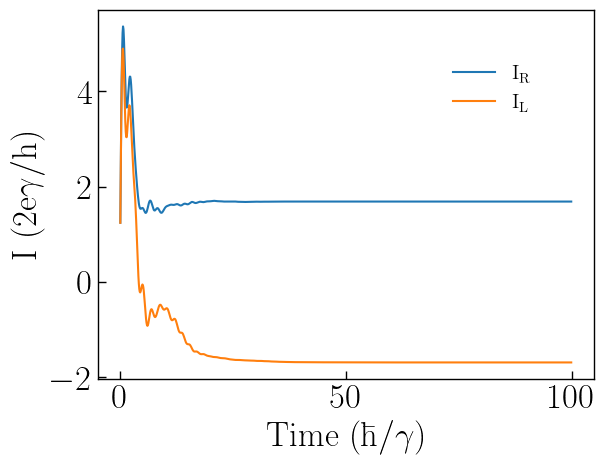

PyObject <matplotlib.legend.Legend object at 0x7fd32908aea0>

In [9]:
fig,axs = plt.subplots(1,1)
axs.plot(obs.t,obs.Iα[1,:]*pi, label = raw"$\mathrm{I_R}$")  ### Units of 2e/h 
axs.plot(obs.t,obs.Iα[2,:]*pi, label = raw"$\mathrm{I_L}$")
axs.set_ylabel(L"$\mathrm{I\ (2e\gamma/h)}$", fontsize = fs)
axs.set_xlabel(raw"$\mathrm{Time\ (\hbar/\gamma)}$",fontsize = fs)
axs.tick_params(axis="both", which="both", labelsize=fs,direction="in", length=6,width=1)
axs.ticklabel_format(axis="y", style="sci", scilimits=(-1,2), useMathText=true)
axs.yaxis.offsetText.set_fontsize(fs)
plt.legend(frameon = false, fontsize = fs-10, loc= (0.7,  0.7))

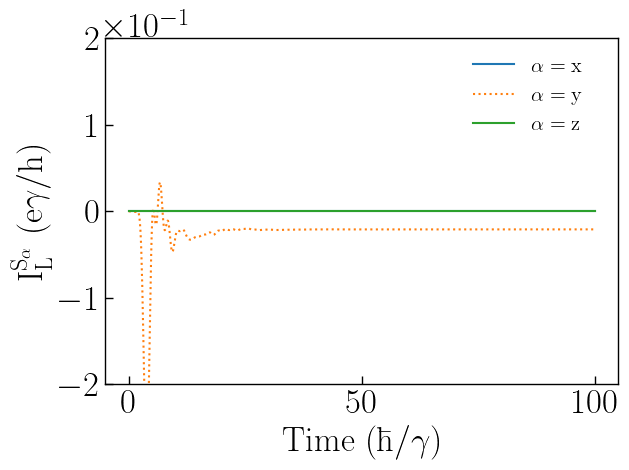

In [10]:
fig,axs = plt.subplots(1,1)
axs.plot(obs.t,obs.Iαx[1,1,:], label = raw"$\mathrm{\alpha = x}$")
axs.plot(obs.t,obs.Iαx[1,2,:], label = raw"$\mathrm{\alpha = y}$",ls=":")
axs.plot(obs.t,obs.Iαx[1,3,:], label = raw"$\mathrm{\alpha = z}$")

axs.set_ylabel(raw"$\mathrm{I^{S_{\alpha}}_L\ (e\gamma/h)}$", fontsize = fs)
axs.set_xlabel(raw"$\mathrm{Time\ (\hbar/\gamma)}$",fontsize = fs)
axs.tick_params(axis="both", which="both", labelsize=fs,direction="in", length=6,width=1)
axs.ticklabel_format(axis="y", style="sci", scilimits=(-1,2), useMathText=true)
axs.yaxis.offsetText.set_fontsize(fs)
#axs.axhline(0.08)
plt.legend(frameon = false, fontsize = fs-10, loc= (0.7,  0.7))
axs.set_ylim(-2e-1,2e-1)
#plt.xlim(0,200)
plt.tight_layout()

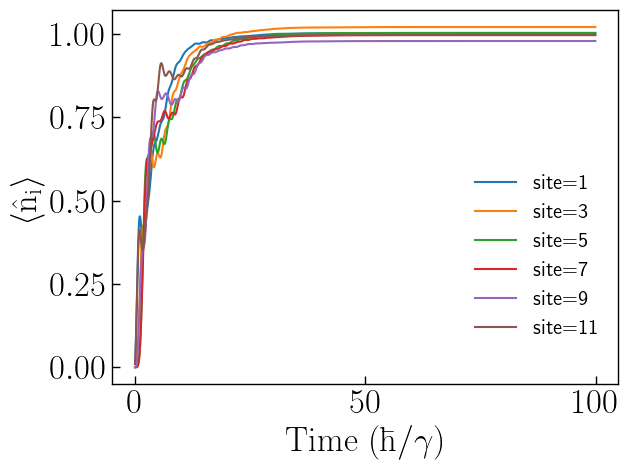

In [11]:
fig,axs =  plt.subplots(1,1)
site = 1
sites = 1:2:12#range(1,12)
for site in sites
    axs.plot(obs.t,obs.n_i[site,:],label= "site=$(site)")#,alpha =1-0.2*i ) ### Charge bound current
end

axs.set_ylabel(raw"$\langle\mathrm{\hat{n}_i}\rangle$", fontsize = fs)
axs.set_xlabel(raw"$\mathrm{Time\ (\hbar/\gamma)}$",fontsize = fs)
axs.tick_params(axis="both", which="both", labelsize=fs,direction="in", length=6,width=1)
axs.ticklabel_format(axis="y", style="sci", scilimits=(-1,2), useMathText=true)
axs.yaxis.offsetText.set_fontsize(fs)
plt.legend(frameon = false, fontsize = fs-10, loc= (0.7,  0.1))
plt.tight_layout()

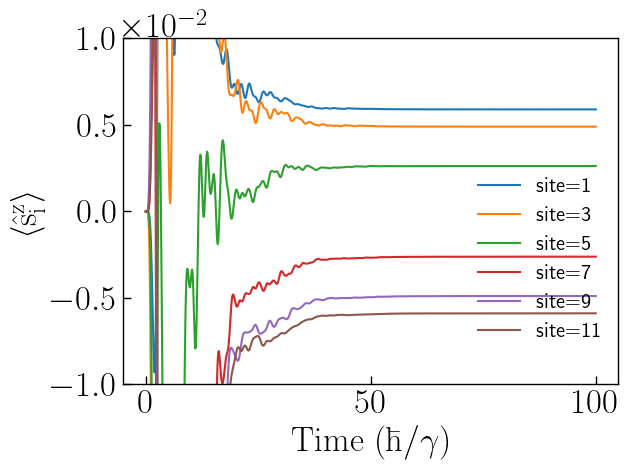

In [12]:
fig,axs =  plt.subplots(1,1)
site = 1
sites = 1:2:12#range(1,4)
for site in sites
    #axs.plot(obs2.t,obs.σx_i[site,1,:],label= "site=$(site)")#,alpha =1-0.2*i ) ### Charge bound current
    #axs.plot(obs.t,obs.σx_i[site,2,:],label= raw"$\alpha=y$ ")
    axs.plot(obs.t,obs.σx_i[site,2,:],label= "site=$(site)")
    #axs.plot(obs2.t .+obs.t[end],obs2.σx_i[site,3,:],label= raw"$\alpha=z$ ")
end

axs.set_ylabel(raw"$\langle\mathrm{\hat{s}^{z}_i}\rangle$", fontsize = fs)
axs.set_xlabel(raw"$\mathrm{Time\ (\hbar/\gamma)}$",fontsize = fs)
axs.tick_params(axis="both", which="both", labelsize=fs,direction="in", length=6,width=1)
axs.ticklabel_format(axis="y", style="sci", scilimits=(-1,2), useMathText=true)
axs.yaxis.offsetText.set_fontsize(fs)
plt.legend(frameon = false, fontsize = fs-10, loc= (0.7,  0.1))
plt.ylim(-1e-2,1e-2)
#plt.xlim(200,300)
plt.tight_layout()

In [38]:
# Time to evolve one step 
using BenchmarkTools
p          = init_params(Nx = 10, Ny = 20)
du =similar(p.u)
u = p.u
@btime eom_tdnegf!($du, $u, $p, 0.0) 

  2.122 s (3 allocations: 144 bytes)
